<a href="https://colab.research.google.com/github/skylar1218/ML-Project---Predicting-Disease-Spread/blob/master/Skylar_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd drive

/content/drive


# Import Data

In [0]:
# import package
import numpy as np
import pandas as pd

In [0]:
# import csv files
url = "https://raw.githubusercontent.com/skylar1218/ML-Project---Predicting-Disease-Spread/master/data/dengue_features_train.csv"
dengue_features_train = pd.read_csv(url)

In [0]:
url = "https://raw.githubusercontent.com/skylar1218/ML-Project---Predicting-Disease-Spread/master/data/dengue_labels_train.csv"
dengue_labels_train = pd.read_csv(url)

In [0]:
url = 'https://raw.githubusercontent.com/skylar1218/ML-Project---Predicting-Disease-Spread/master/data/dengue_features_test.csv'
dengue_features_test = pd.read_csv(url)

# Data Description

In [0]:
dengue_features_train

In [0]:
dengue_features_train.shape

In [0]:
dengue_labels_train

In [0]:
dengue_labels_train.shape

In [0]:
dengue_features_test

In [0]:
dengue_features_test.shape

In [0]:
dengue_features_train.info()

In [0]:
dengue_features_train.describe()

In [0]:
# plot histogram for all features
%matplotlib inline
import matplotlib.pyplot as plt
dengue_features_train.hist(bins=50, figsize=(20,15))

plt.show()

In [0]:
# check missing for each column
# training data
dengue_features_train.isnull().sum(axis=0)

In [0]:
# test data
dengue_features_test.isnull().sum(axis=0)

In [0]:
tr_feature = dengue_features_train.copy()
tr_label = dengue_labels_train.copy()
te_feature = dengue_features_test.copy()

print(tr_feature.shape)
print(tr_label.shape)
print(te_feature.shape)

(1456, 24)
(1456, 4)
(416, 24)


## Delect Row with Week of Year = 53

In [0]:
tr_feature[tr_feature.isnull().sum(axis=1)>15]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
87,sj,1992,1,1992-01-01,0.125100,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,sj,1993,53,1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399,sj,1998,1,1998-01-01,0.045500,0.047800,0.123986,0.083443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,sj,1999,53,1999-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
711,sj,2004,1,2004-01-01,-0.268300,-0.123700,0.223757,0.176543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
763,sj,2005,53,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1118,iq,2004,1,2004-01-01,0.202571,0.198967,0.244557,0.187957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1170,iq,2005,53,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1378,iq,2009,1,2009-01-01,0.151286,0.161686,0.153271,0.119443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1430,iq,2010,53,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
indexNames = tr_feature[tr_feature['weekofyear'] == 53].index
indexNames

Int64Index([139, 451, 763, 1170, 1430], dtype='int64')

In [0]:
# delete these row indexes from dengue_features_train
X_train1 = tr_feature.drop(indexNames)
y_train1 = tr_label.drop(indexNames)

print(X_train1.shape)
print(y_train1.shape)

(1455, 24)
(1455, 4)


## Feature Engineering on Trainning Data

In [0]:
# create lag variables
df = X_train1.groupby(["city"]).shift(1)
df = df.drop(['year', 'week_start_date'], axis=1)

# rename lag variables
df.columns = df.columns + "_lag1"

In [0]:
df.head()

In [0]:
X_train1 = pd.concat([X_train1, df], axis=1)

print(X_train1.shape)

(1455, 45)


In [0]:
X_train1.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_lag1,ndvi_ne_lag1,ndvi_nw_lag1,ndvi_se_lag1,ndvi_sw_lag1,precipitation_amt_mm_lag1,reanalysis_air_temp_k_lag1,reanalysis_avg_temp_k_lag1,reanalysis_dew_point_temp_k_lag1,reanalysis_max_air_temp_k_lag1,reanalysis_min_air_temp_k_lag1,reanalysis_precip_amt_kg_per_m2_lag1,reanalysis_relative_humidity_percent_lag1,reanalysis_sat_precip_amt_mm_lag1,reanalysis_specific_humidity_g_per_kg_lag1,reanalysis_tdtr_k_lag1,station_avg_temp_c_lag1,station_diur_temp_rng_c_lag1,station_max_temp_c_lag1,station_min_temp_c_lag1,station_precip_mm_lag1
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0


In [0]:
# create city dummy
X_train1['city_sj'] = [1 if x == 'sj' else 0 for x in X_train1['city']]

print(X_train1.shape)

(1455, 46)


In [0]:
X_train1.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_lag1,ndvi_ne_lag1,ndvi_nw_lag1,ndvi_se_lag1,ndvi_sw_lag1,precipitation_amt_mm_lag1,reanalysis_air_temp_k_lag1,reanalysis_avg_temp_k_lag1,reanalysis_dew_point_temp_k_lag1,reanalysis_max_air_temp_k_lag1,reanalysis_min_air_temp_k_lag1,reanalysis_precip_amt_kg_per_m2_lag1,reanalysis_relative_humidity_percent_lag1,reanalysis_sat_precip_amt_mm_lag1,reanalysis_specific_humidity_g_per_kg_lag1,reanalysis_tdtr_k_lag1,station_avg_temp_c_lag1,station_diur_temp_rng_c_lag1,station_max_temp_c_lag1,station_min_temp_c_lag1,station_precip_mm_lag1,city_sj
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,1
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,1
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,1
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,1


In [0]:
X_train1 = X_train1.drop(['city', 'year', 'week_start_date'], axis=1)

print(X_train1.shape)

(1455, 43)


In [0]:
X_train1.head()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_lag1,ndvi_ne_lag1,ndvi_nw_lag1,ndvi_se_lag1,ndvi_sw_lag1,precipitation_amt_mm_lag1,reanalysis_air_temp_k_lag1,reanalysis_avg_temp_k_lag1,reanalysis_dew_point_temp_k_lag1,reanalysis_max_air_temp_k_lag1,reanalysis_min_air_temp_k_lag1,reanalysis_precip_amt_kg_per_m2_lag1,reanalysis_relative_humidity_percent_lag1,reanalysis_sat_precip_amt_mm_lag1,reanalysis_specific_humidity_g_per_kg_lag1,reanalysis_tdtr_k_lag1,station_avg_temp_c_lag1,station_diur_temp_rng_c_lag1,station_max_temp_c_lag1,station_min_temp_c_lag1,station_precip_mm_lag1,city_sj
0,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,18.0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,1
2,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,19.0,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,1
3,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,20.0,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,1
4,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,21.0,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,1


## Feature Engineering on Test Data

In [0]:
# before create the lag variable in test data
# we need to take the last record from each city from the training data
# and attach them into the test data
sj = tr_feature[(tr_feature['city'] == 'sj') & (tr_feature['year'] == 2008) & (tr_feature['weekofyear'] == 17)]
iq = tr_feature[(tr_feature['city'] == 'iq') & (tr_feature['year'] == 2010) & (tr_feature['weekofyear'] == 25)]

In [0]:
sj

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
935,sj,2008,17,2008-04-22,-0.037,-0.010367,0.077314,0.090586,0.0,298.672857,298.692857,294.28,300.9,295.9,2.17,76.96,0.0,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3


In [0]:
sj_test = te_feature[te_feature['city'] == 'sj']
iq_test = te_feature[te_feature['city'] == 'iq']

In [0]:
iq_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
260,iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,293.7,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
261,iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,292.2,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
262,iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,292.5,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
263,iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,289.3,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
264,iq,2010,30,2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,290.5,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0


In [0]:
X_test1 = pd.concat([sj, sj_test, iq, iq_test], axis=0)
print(X_test1.shape)

(418, 24)


In [0]:
# create lag variables
df = X_test1.groupby(["city"]).shift(1)
df = df.drop(['year', 'week_start_date'], axis=1)

# rename lag variables
df.columns = df.columns + "_lag1"

In [0]:
df.head()

In [0]:
X_test1 = pd.concat([X_test1, df], axis=1)

print(X_test1.shape)

(418, 45)


In [0]:
X_test1.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_lag1,ndvi_ne_lag1,ndvi_nw_lag1,ndvi_se_lag1,ndvi_sw_lag1,precipitation_amt_mm_lag1,reanalysis_air_temp_k_lag1,reanalysis_avg_temp_k_lag1,reanalysis_dew_point_temp_k_lag1,reanalysis_max_air_temp_k_lag1,reanalysis_min_air_temp_k_lag1,reanalysis_precip_amt_kg_per_m2_lag1,reanalysis_relative_humidity_percent_lag1,reanalysis_sat_precip_amt_mm_lag1,reanalysis_specific_humidity_g_per_kg_lag1,reanalysis_tdtr_k_lag1,station_avg_temp_c_lag1,station_diur_temp_rng_c_lag1,station_max_temp_c_lag1,station_min_temp_c_lag1,station_precip_mm_lag1
935,sj,2008,17,2008-04-22,-0.0370,-0.010367,0.077314,0.090586,0.00,298.672857,298.692857,294.280000,300.9,295.9,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,17.0,-0.0370,-0.010367,0.077314,0.090586,0.00,298.672857,298.692857,294.280000,300.9,295.9,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,18.0,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,19.0,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,20.0,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0


In [0]:
# create city dummy
X_test1['city_sj'] = [1 if x == 'sj' else 0 for x in X_test1['city']]

print(X_test1.shape)

(418, 46)


In [0]:
# drop the training data
indexNames = X_test1[(X_test1['city'] == 'sj') & (X_test1['year'] == 2008) & (X_test1['weekofyear'] == 17)].index
X_test1.drop(indexNames , inplace=True)

In [0]:
indexNames = X_test1[(X_test1['city'] == 'iq') & (X_test1['year'] == 2010) & (X_test1['weekofyear'] == 25)].index
X_test1.drop(indexNames , inplace=True)

print(X_test1.shape)

(416, 46)


In [0]:
X_test1.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_lag1,ndvi_ne_lag1,ndvi_nw_lag1,ndvi_se_lag1,ndvi_sw_lag1,precipitation_amt_mm_lag1,reanalysis_air_temp_k_lag1,reanalysis_avg_temp_k_lag1,reanalysis_dew_point_temp_k_lag1,reanalysis_max_air_temp_k_lag1,reanalysis_min_air_temp_k_lag1,reanalysis_precip_amt_kg_per_m2_lag1,reanalysis_relative_humidity_percent_lag1,reanalysis_sat_precip_amt_mm_lag1,reanalysis_specific_humidity_g_per_kg_lag1,reanalysis_tdtr_k_lag1,station_avg_temp_c_lag1,station_diur_temp_rng_c_lag1,station_max_temp_c_lag1,station_min_temp_c_lag1,station_precip_mm_lag1,city_sj
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,17.0,-0.0370,-0.010367,0.077314,0.090586,0.00,298.672857,298.692857,294.280000,300.9,295.9,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3,1
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,18.0,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,1
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,19.0,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,1
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,20.0,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,1
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,21.0,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,1


In [0]:
X_test1 = X_test1.drop(['city', 'year', 'week_start_date'], axis=1)

print(X_test1.shape)

(416, 43)


In [0]:
X_test1.head()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_lag1,ndvi_ne_lag1,ndvi_nw_lag1,ndvi_se_lag1,ndvi_sw_lag1,precipitation_amt_mm_lag1,reanalysis_air_temp_k_lag1,reanalysis_avg_temp_k_lag1,reanalysis_dew_point_temp_k_lag1,reanalysis_max_air_temp_k_lag1,reanalysis_min_air_temp_k_lag1,reanalysis_precip_amt_kg_per_m2_lag1,reanalysis_relative_humidity_percent_lag1,reanalysis_sat_precip_amt_mm_lag1,reanalysis_specific_humidity_g_per_kg_lag1,reanalysis_tdtr_k_lag1,station_avg_temp_c_lag1,station_diur_temp_rng_c_lag1,station_max_temp_c_lag1,station_min_temp_c_lag1,station_precip_mm_lag1,city_sj
0,18,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,17.0,-0.0370,-0.010367,0.077314,0.090586,0.00,298.672857,298.692857,294.280000,300.9,295.9,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3,1
1,19,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,18.0,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,1
2,20,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,19.0,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,1
3,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,20.0,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,1
4,22,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,21.0,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,1


## Visualize Correlation between Total Cases and Other Variables

In [0]:
df = dengue_features_train.copy()
df["total_cases"] =  dengue_labels_train.total_cases

In [0]:
df_sj = df[df['city'] == 'sj']
df_iq = df[df['city'] == 'iq']

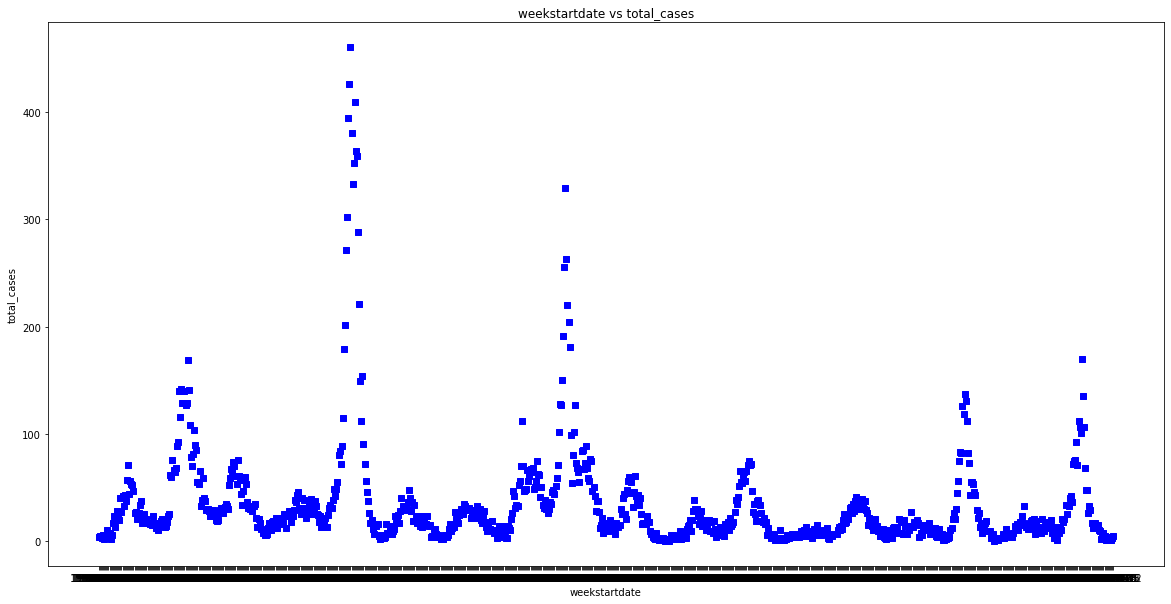

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(df_sj.week_start_date, df_sj.total_cases, c = "blue", marker = "s")
plt.title("weekstartdate vs total_cases")
plt.xlabel("weekstartdate")
plt.ylabel("total_cases")
plt.show()

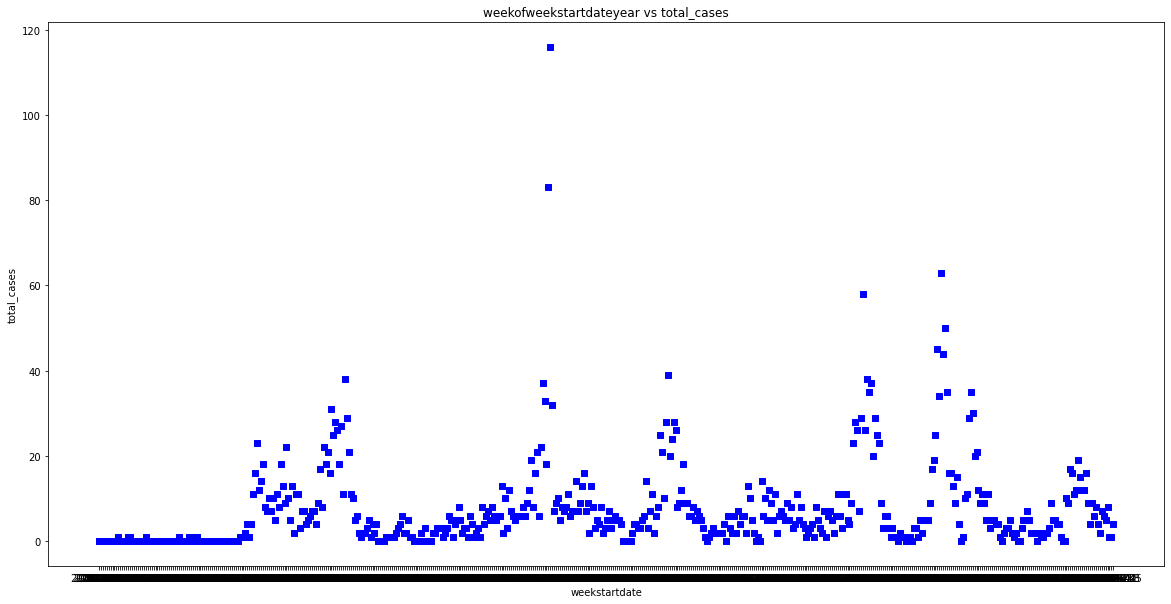

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(df_iq.week_start_date, df_iq.total_cases, c = "blue", marker = "s")
plt.title("weekstartdate vs total_cases")
plt.xlabel("weekstartdate")
plt.ylabel("total_cases")
plt.show()

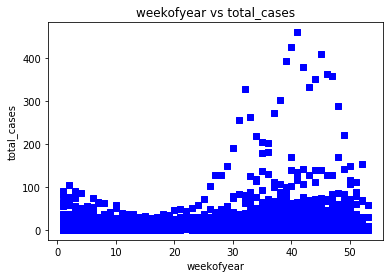

In [0]:
import matplotlib.pyplot as plt

plt.scatter(df.weekofyear, df.total_cases, c = "blue", marker = "s")
plt.title("weekofyear vs total_cases")
plt.xlabel("weekofyear")
plt.ylabel("total_cases")
plt.show()

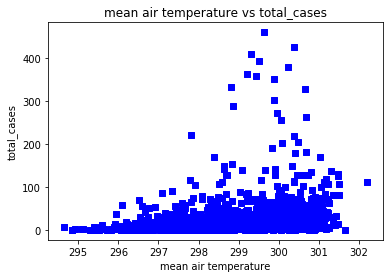

In [0]:
plt.scatter(df.reanalysis_air_temp_k, df.total_cases, c = "blue", marker = "s")
plt.title("mean air temperature vs total_cases")
plt.xlabel("mean air temperature")
plt.ylabel("total_cases")
plt.show()

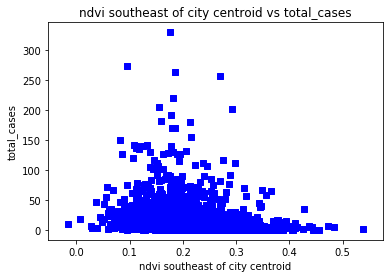

In [0]:
plt.scatter(df.ndvi_se, df.total_cases, c = "blue", marker = "s")
plt.title("ndvi southeast of city centroid vs total_cases")
plt.xlabel("ndvi southeast of city centroid")
plt.ylabel("total_cases")
plt.show()

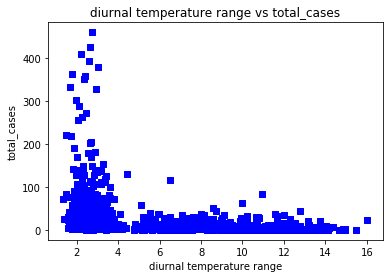

In [0]:
plt.scatter(df.reanalysis_tdtr_k, df.total_cases, c = "blue", marker = "s")
plt.title("diurnal temperature range vs total_cases")
plt.xlabel("diurnal temperature range")
plt.ylabel("total_cases")
plt.show()

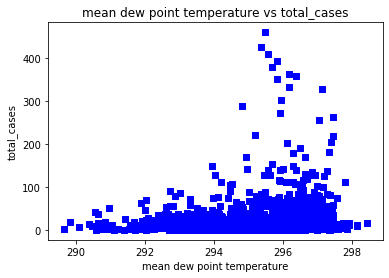

In [0]:
plt.scatter(df.reanalysis_dew_point_temp_k, df.total_cases, c = "blue", marker = "s")
plt.title("mean dew point temperature vs total_cases")
plt.xlabel("mean dew point temperature")
plt.ylabel("total_cases")
plt.show()

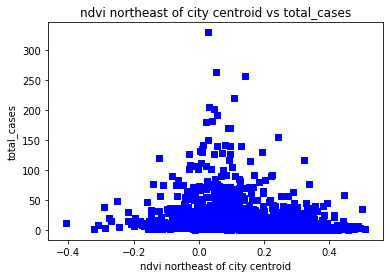

In [0]:
plt.scatter(df.ndvi_ne, df.total_cases, c = "blue", marker = "s")
plt.title("ndvi northeast of city centroid vs total_cases")
plt.xlabel("ndvi northeast of city centroid")
plt.ylabel("total_cases")
plt.show()

## Split the Data into Trainning and Validation Data

*   X_train1
*   y_train1
*   X-test1


In [0]:
print(X_train1.shape)
print(y_train1.shape)
print(X_test1.shape)

(1455, 43)
(1455, 4)
(416, 43)


In [0]:
y_train1.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [0]:
X_train1['total_cases'] = y_train1['total_cases']

In [0]:
X_train1.head()

In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(X_train1, test_size=0.3, random_state=42)

In [0]:
train.head()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_lag1,ndvi_ne_lag1,ndvi_nw_lag1,ndvi_se_lag1,ndvi_sw_lag1,precipitation_amt_mm_lag1,reanalysis_air_temp_k_lag1,reanalysis_avg_temp_k_lag1,reanalysis_dew_point_temp_k_lag1,reanalysis_max_air_temp_k_lag1,reanalysis_min_air_temp_k_lag1,reanalysis_precip_amt_kg_per_m2_lag1,reanalysis_relative_humidity_percent_lag1,reanalysis_sat_precip_amt_mm_lag1,reanalysis_specific_humidity_g_per_kg_lag1,reanalysis_tdtr_k_lag1,station_avg_temp_c_lag1,station_diur_temp_rng_c_lag1,station_max_temp_c_lag1,station_min_temp_c_lag1,station_precip_mm_lag1,city_sj,total_cases
464,13,0.054100,-0.098100,0.157267,0.137057,15.91,298.308571,298.414286,294.377143,300.4,296.1,8.90,78.910000,15.91,15.732857,2.314286,25.742857,6.900000,30.6,21.7,7.9,12.0,0.135000,0.032333,0.198800,0.183057,5.24,298.222857,298.450000,293.230000,300.5,296.3,3.10,73.940000,5.24,14.671429,2.842857,25.671429,7.671429,30.6,21.1,0.0,1,22
471,20,NaN,0.090667,0.194471,0.169157,33.82,299.775714,299.935714,295.268571,302.6,297.0,22.10,76.598571,33.82,16.651429,3.185714,27.828571,7.328571,33.3,23.3,14.3,19.0,NaN,0.057800,0.080400,0.081120,46.50,299.098571,299.121429,294.572857,301.0,297.2,14.28,76.308571,46.50,15.967143,2.585714,26.957143,7.628571,32.8,21.7,73.1,1,20
1328,3,0.188229,0.220829,0.233243,0.169971,95.97,298.034286,299.478571,297.090000,305.5,292.4,63.92,94.968571,95.97,18.865714,8.585714,27.433333,9.466667,33.8,21.8,125.3,2.0,0.444933,0.275850,0.356900,0.469729,71.84,296.095714,296.535714,295.200000,302.1,293.3,62.61,95.280000,71.84,16.681429,5.100000,25.800000,6.300000,31.4,22.6,104.4,0,26
435,37,0.074650,0.057967,0.151886,0.122000,72.73,300.147143,300.200000,297.160000,302.0,298.7,73.60,84.002857,72.73,18.724286,2.028571,28.328571,6.842857,32.2,24.4,61.3,36.0,0.038800,0.054033,0.158543,0.145643,47.74,300.687143,300.707143,297.328571,303.4,298.4,52.50,82.192857,47.74,18.908571,2.900000,28.757143,7.128571,33.9,22.8,27.4,1,99
1206,36,0.335429,0.200714,0.322886,0.309143,36.98,300.058571,301.214286,294.005714,309.3,293.4,4.20,71.971429,36.98,15.518571,13.714286,NaN,NaN,NaN,21.8,44.0,35.0,0.456833,0.359583,0.359450,0.380117,12.81,298.184286,299.371429,293.918571,308.6,292.4,11.00,79.647143,12.81,15.428571,10.942857,26.800000,10.250000,35.2,21.4,37.0,0,0


In [0]:
train_feature = train.drop(['total_cases'], axis=1)
train_label = train.total_cases

val_feature = val.drop(['total_cases'], axis=1)
val_label = val.total_cases

In [0]:
print(train_feature.shape)
print(train_label.shape)

print(val_feature.shape)
print(val_label.shape)

(1018, 43)
(1018,)
(437, 43)
(437,)


# XGBoost

## Fit a Default XGBoost

In [0]:
import xgboost

xgb_rg = xgboost.XGBRegressor(seed=42) 

In [0]:
xgb_rg.fit(train_feature, train_label)

[22:35:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             silent=None, subsample=1, verbosity=1)

In [0]:
val_pred = xgb_rg.predict(val_feature)

In [0]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(val_label, val_pred)

17.252850139986734

## Cross-Validation

In [0]:
import xgboost as xgb

data_dmatrix = xgb.DMatrix(data=train_feature, label=train_label)

In [0]:
params = {"objective":"reg:linear", 'colsample_bytree': 0.3,'learning_rate': 0.1,
          'max_depth': 5, 'alpha': 10}

In [0]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=20, num_boost_round=50, early_stopping_rounds=10, metrics="mae", as_pandas=True, seed=42)

[22:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
cv_results.head()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,21.061777,0.255928,21.100456,5.031635
1,19.382420,0.244875,19.555874,4.844859
2,18.011351,0.242319,18.382968,4.675678
3,16.880823,0.240018,17.451412,4.425970
4,15.961141,0.236394,16.745228,4.316698


In [0]:
print((cv_results["test-mae-mean"]).tail(1))

17    14.634856
Name: test-mae-mean, dtype: float64


## Feature Importance

In [0]:
# print feature importance
# order by importance
listofTuples = sorted(xgb_rg.get_booster().get_score(importance_type='weight').items() ,  key=lambda x: x[1], reverse=True)

for elem in listofTuples :
    print(elem[0] , " ::" , elem[1] )

weekofyear  :: 62
ndvi_se  :: 48
ndvi_ne  :: 38
reanalysis_air_temp_k  :: 37
station_avg_temp_c_lag1  :: 31
ndvi_se_lag1  :: 30
reanalysis_tdtr_k  :: 28
reanalysis_tdtr_k_lag1  :: 28
reanalysis_min_air_temp_k_lag1  :: 23
station_min_temp_c_lag1  :: 23
precipitation_amt_mm_lag1  :: 20
precipitation_amt_mm  :: 19
reanalysis_dew_point_temp_k  :: 19
reanalysis_dew_point_temp_k_lag1  :: 18
weekofyear_lag1  :: 16
station_diur_temp_rng_c_lag1  :: 16
reanalysis_precip_amt_kg_per_m2_lag1  :: 14
ndvi_ne_lag1  :: 14
reanalysis_precip_amt_kg_per_m2  :: 14
ndvi_nw_lag1  :: 14
station_diur_temp_rng_c  :: 14
reanalysis_min_air_temp_k  :: 13
reanalysis_air_temp_k_lag1  :: 13
reanalysis_avg_temp_k_lag1  :: 13
ndvi_sw_lag1  :: 12
station_precip_mm  :: 12
ndvi_sw  :: 10
station_avg_temp_c  :: 9
station_min_temp_c  :: 9
ndvi_nw  :: 9
reanalysis_relative_humidity_percent  :: 9
reanalysis_specific_humidity_g_per_kg  :: 6
reanalysis_max_air_temp_k_lag1  :: 5
reanalysis_max_air_temp_k  :: 5
station_max_temp_c

## Fine Tune Hyperparameters

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform
from time import time

# set parameter range 
# https://xgboost.readthedocs.io/en/latest/parameter.html
param_distribs = {
    'booster': ['gbtree'],
    'eval_metric': ['mae'],
    'eta': uniform(loc=0, scale=1),
    'min_child_weight': uniform(loc=0, scale=5),
    'max_depth': randint(low=1, high=10),
    'gamma': uniform(loc=0, scale=10),
    'subsample': uniform(loc=0.5, scale=1),
    'colsample_bytree': uniform(loc=0.5, scale=1),
    'lambda': uniform(loc=0, scale=10),
    'alpha': uniform(loc=0, scale=10),
    'scale_pos_weight': uniform(loc=0, scale=10),
}

In [0]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
rnd_search_xgb = RandomizedSearchCV(xgb_reg, param_distributions=param_distribs, n_jobs=-1, n_iter=500, cv=5, scoring='neg_mean_absolute_error', random_state=42)

start = time()
rnd_search_xgb.fit(train_feature, train_label)
print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(rnd_search_xgb.cv_results_['params'])))

[23:16:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RandomizedSearchCV took 218.89 seconds for 500 candidate parameter settings.


In [0]:
"{:.4f}".format(-rnd_search_xgb.best_score_)

'14.8681'

In [0]:
rnd_search_xgb.best_params_

{'alpha': 1.1443151861235856,
 'booster': 'gbtree',
 'colsample_bytree': 0.5087061470625436,
 'eta': 0.1555714368693023,
 'eval_metric': 'mae',
 'gamma': 2.072729790676676,
 'lambda': 6.3058094158309235,
 'max_depth': 8,
 'min_child_weight': 0.6483948911211768,
 'scale_pos_weight': 2.5646306101676597,
 'subsample': 0.8553197484738877}

In [0]:
best_xgb = rnd_search_xgb.best_estimator_

In [0]:
val_pred = best_xgb.predict(val_feature)

print("Mean Absolute Error for XGBoost: ", "{:.4f}".format(mean_absolute_error(val_label, val_pred)))

Mean Absolute Error for XGBoost:  16.8903


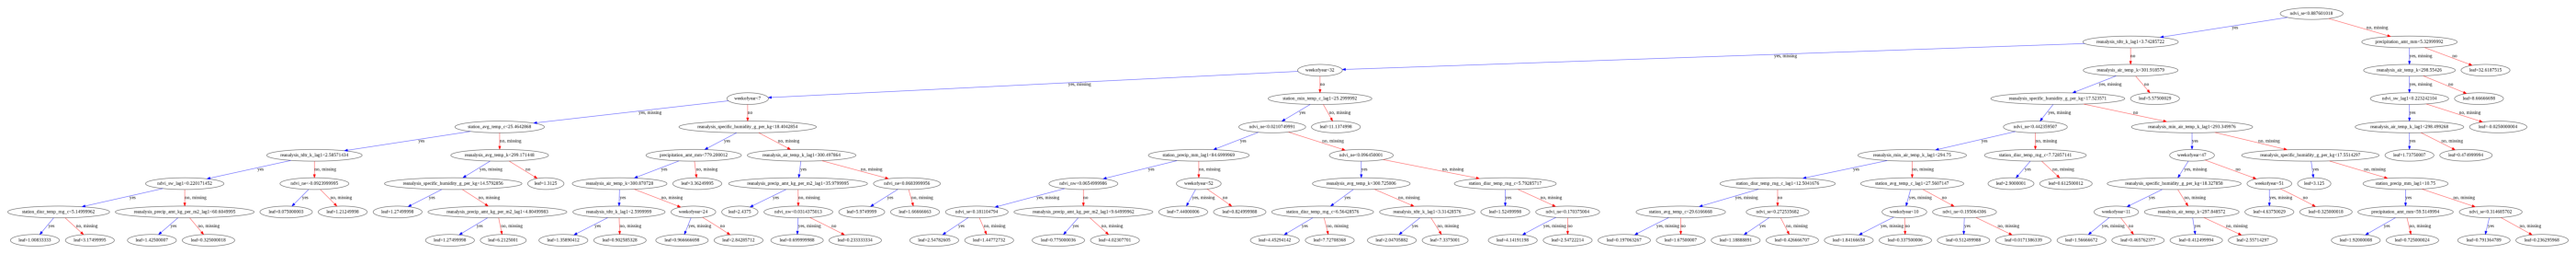

In [0]:
import matplotlib.pyplot as plt

xgb.plot_tree(best_xgb, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

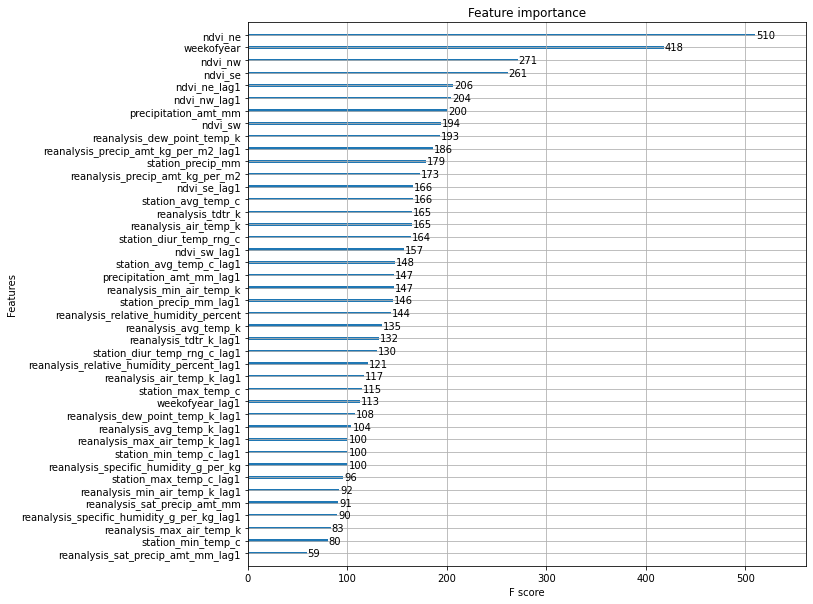

In [0]:
xgb.plot_importance(best_xgb)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

## Predit Test Data Using Best Hyperparameter Model

In [0]:
X_test1 .head()

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear_lag1,ndvi_ne_lag1,ndvi_nw_lag1,ndvi_se_lag1,ndvi_sw_lag1,precipitation_amt_mm_lag1,reanalysis_air_temp_k_lag1,reanalysis_avg_temp_k_lag1,reanalysis_dew_point_temp_k_lag1,reanalysis_max_air_temp_k_lag1,reanalysis_min_air_temp_k_lag1,reanalysis_precip_amt_kg_per_m2_lag1,reanalysis_relative_humidity_percent_lag1,reanalysis_sat_precip_amt_mm_lag1,reanalysis_specific_humidity_g_per_kg_lag1,reanalysis_tdtr_k_lag1,station_avg_temp_c_lag1,station_diur_temp_rng_c_lag1,station_max_temp_c_lag1,station_min_temp_c_lag1,station_precip_mm_lag1,city_sj
0,18,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,17.0,-0.0370,-0.010367,0.077314,0.090586,0.00,298.672857,298.692857,294.280000,300.9,295.9,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3,1
1,19,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,18.0,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,1
2,20,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,19.0,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,1
3,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,20.0,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,1
4,22,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,21.0,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,1


In [0]:
# predict on test data
te_pred = best_xgb.predict(X_test1)

In [0]:
# create submission dataframe
submission = dengue_features_test.iloc[:,0:3]
submission['total_cases'] = te_pred.astype(int)

In [0]:
submission.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,6
1,sj,2008,19,4
2,sj,2008,20,11
3,sj,2008,21,16
4,sj,2008,22,30


In [0]:
upload = './My Drive/submission_xgboost.csv'
submission.to_csv(upload, index = False)